## Concordance of terms - Scottish Gazetters - Full dataset


Steps:
- Create a new mapping and index in ElasticSearch called **gazetteer-scotland** to store the gazetters collections.
- Store in this ElasticSearch index (using the **write_pages_df_es** query) the pre-processed (which includes long-S fix, hyphen fix, normalization, lemmatization, stemming) along with the metadata (e.g. Year, Edition, Tittle, Archive Name, FileName, Model, etc …):

  `spark-submit --driver-class-path elasticsearch-hadoop-7.5.0/dist/elasticsearch-hadoop-7.5.0.jar --jars elasticsearch-hadoop-7.5.0/dist/elasticsearch-hadoop-7.5.0.jar  --py-files defoe.zip defoe/run_query.py nls-gaz-1.txt nls defoe.nls.queries.write_pages_df_es queries/es_properties_edina_gaz.yml`
 
So, if we check the data in in ElasticSerch, we can see that the preprocessed data for the scottish gazetters
 
`curl -X GET "172.16.51.140:9200/_cat/indices?v"`
>> green  open   gazetteer-scotland                 JEyK-SUHSgaYMZYpuEjnHw   1   0      13088            0    493.7mb        484.7mb`
 
 
- Run the **window_concordance_by_date** query for calculating the concordance of each term ( using a window of 10 words at the beginning and at the end of each term). I used the cleaned and normalized text (not the lemmatization or stemming) that we have saved in ElastiSearch

        Terms: :
        - stirling
        - aberdeen
        - dundee
        - glasgow
        - inverness
        - perth
        - edinburgh
        - scotland

 `spark-submit --driver-class-path elasticsearch-hadoop-7.5.0/dist/elasticsearch-hadoop-7.5.0.jar --jars elasticsearch-hadoop-7.5.0/dist/elasticsearch-hadoop-7.5.0.jar --py-files defoe.zip defoe/run_query.py es_data_sc_gz.txt es defoe.es.queries.window_concordance_by_date queries/concordance.yml -r results_window_concordance -n 16`
 
 
- Once having the results, I have created a Notebook for exporting the YML results into CSV - https://github.com/alan-turing-institute/defoe_visualization/blob/master/Scottish_Gazetteer/Extract%20Results%20Window.ipynb –
 
- This notebook displays the concordance of each term , plot the frequency (raw and normalized) of each of the terms over the years, and creates cumulative plots, also raw and normalized.



In [1]:
import pandas as pd 
import yaml
import sys
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rcParams['figure.dpi']=130
pd.options.display.max_colwidth = 90 

Lexicon:
- stirling
- aberdeen
- dundee
- glasgow
- inverness
- perth
- edinburgh
- scotland

#### Functions 

In [2]:
def read_query_results(filename):
    with open(filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results

In [3]:
def visualize_term(df, term):
    df_term=df.loc[df['search_term'] == term]
    term_list=df_term['sequence']
    date_list= df_term['date']
    window_left=[]
    window_right=[]
    term_l=[]
    for i in term_list:
        idx=i.index(term)
        term_size=len(term)+2
        window_left.append(i[2:idx-3])
        window_right.append(i[idx+term_size:])
        term_l.append(term)
    v_d = {'year':date_list, 'words_left':window_left, 'term':term_l, 'words_right': window_right}
    v_df = pd.DataFrame(v_d)
    f_vdf= v_df[['year','words_left', 'term', 'words_right']]
    return f_vdf

In [4]:
def freq_count(df):
    freq_count={}
    for i in df["year"]:
        if i not in freq_count:
            freq_count[i]={}
            freq_count[i]=1
                
        else:
            freq_count[i]+=1
    return freq_count

In [5]:
def plot_freq_count(freq_count, term):
    plt.plot(freq_count.keys(), freq_count.values(), 'x')
    plt.xlabel('Years')
    plt.ylabel('Frequency')
    plt.title('Frequency of ' + term + ' term')
    plt.show()

In [6]:
def plot_normalize_freq(publication, freq_results, term):
    normed_results = {}
    for year in freq_results:
        if year>0:
            normed_results[year] = freq_results[year]/float(publication[year][2])
    plt.plot(normed_results.keys(), normed_results.values(), 'x')
    plt.xlabel('Years')
    plt.ylabel('Normalized Frequency')
    plt.title('Normalized Frequency of ' + term + ' term')
    plt.show()
    return normed_results

In [7]:
# Plot two lines with different scales on the same plot
def cumulative_plot(freq_term1, freq_term2, term1, term2, freq_type):
    fig = plt.figure(figsize=(12, 6))
    years=set()
    line_weight = 3
    alpha = .5
    plt.plot(*zip(*sorted(freq_term1.items())), color='blue', lw=line_weight, alpha=alpha, label=term1, marker='d')
    plt.plot(*zip(*sorted(freq_term2.items())), color='orange', lw=line_weight, alpha=alpha, label=term2, marker='s')

    for y in freq_term1.keys(): 
        years.add(y)
    for y in freq_term2.keys(): 
        years.add(y)
        
    plt.xticks(sorted(list(years)), rotation=50)        
    plt.title('Cumulative yearly - Terms: '+ term1 +' & '+ term2)  
    plt.legend(loc='upper right')
    plt.ticklabel_format(style = 'plain')
    plt.ylabel(freq_type +' Frequency')
    plt.xlabel("Years")
    plt.show()
    

In [8]:
# Plot 5 lines with different scales on the same plot
def total_cumulative_plot(freq_term1, freq_term2, freq_term3, freq_term4, freq_term5, freq_term6, freq_term7, freq_term8, term1, term2, term3, term4, term5, term6, term7, term8, freq_type):
    
    fig = plt.figure(figsize=(12, 6))
    years=set()
    line_weight = 3
    alpha = .5
    plt.plot(*zip(*sorted(freq_term1.items())), color='blue', lw=line_weight, alpha=alpha, label=term1, marker='d')
    plt.plot(*zip(*sorted(freq_term2.items())), color='orange', lw=line_weight, alpha=alpha, label=term2, marker='s')
    plt.plot(*zip(*sorted(freq_term3.items())), color='green', lw=line_weight, alpha=alpha, label=term3, marker='x')
    plt.plot(*zip(*sorted(freq_term4.items())), color='red', lw=line_weight, alpha=alpha, label=term4, marker='d')
    plt.plot(*zip(*sorted(freq_term5.items())), color='black', lw=line_weight, alpha=alpha, label=term5, marker='s')
    plt.plot(*zip(*sorted(freq_term6.items())), color='purple', lw=line_weight, alpha=alpha, label=term6, marker='x')
    plt.plot(*zip(*sorted(freq_term7.items())), color='yellow', lw=line_weight, alpha=alpha, label=term7, marker='d')
    plt.plot(*zip(*sorted(freq_term8.items())), color='brown', lw=line_weight, alpha=alpha, label=term8, marker='s')
    
    for y in freq_term1.keys(): 
        years.add(y)
    for y in freq_term2.keys(): 
        years.add(y)
    for y in freq_term3.keys(): 
        years.add(y)  
    for y in freq_term4.keys(): 
        years.add(y)  
    for y in freq_term5.keys(): 
        years.add(y)    
    for y in freq_term6.keys(): 
        years.add(y)    
    for y in freq_term7.keys(): 
        years.add(y)   
    for y in freq_term8.keys(): 
        years.add(y) 
        
    plt.xticks(sorted(list(years)), rotation=50) 
    
    plt.title('Cumulative yearly - Terms: '+ term1 +' & '+ term2 + ' & '+ term3 +' & '+ term4 + ' & ' + term5 +' & ' + term6 +' & '+ term7 + ' & ' + term8 )
    plt.ticklabel_format(style = 'plain')
    plt.legend(loc='upper left')
    plt.ylabel(freq_type +' Frequency')
    plt.xlabel("Years")
    plt.show()

#### Load the data into a Pandas dataframe

We are renaming the columns of the csv in order to avoi spaces in the column names

In [9]:
df = pd.read_csv("./results_Gazetteer/results_window_concordance_sg.csv") 
# Preview the first 5 lines of the loaded data 
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
# Displaying the dataframe
df.head()

,date,title,edition,archive,filename,search_term,sequence
0,1803,gazetteer of Scotland,1803,/home/tdm/datasets/nls-data-gazetteersOfScotland/97343436,alto/97343538.34.xml,aberdeen,"['bradfute', 'and', 'a', 'constable', 'edinburgh', 'j', 'gillies', 'glasgow', 'j', 'bu..."
1,1803,gazetteer of Scotland,1803,/home/tdm/datasets/nls-data-gazetteersOfScotland/97343436,alto/97343538.34.xml,dundee,"['nobility', 'and', 'gentry', 'roads', 'ic', 'illustrated', 'with', 'an', 'elegant', '..."
2,1803,gazetteer of Scotland,1803,/home/tdm/datasets/nls-data-gazetteersOfScotland/97343436,alto/97343538.34.xml,edinburgh,"['v', 'chalmers', 'castlestreet', 'sold', 'by', 'bell', 'bradfute', 'and', 'a', 'const..."
3,1803,gazetteer of Scotland,1803,/home/tdm/datasets/nls-data-gazetteersOfScotland/97343436,alto/97343538.34.xml,glasgow,"['sold', 'by', 'bell', 'bradfute', 'and', 'a', 'constable', 'edinburgh', 'j', 'gillies..."
4,1803,gazetteer of Scotland,1803,/home/tdm/datasets/nls-data-gazetteersOfScotland/97343436,alto/97343538.34.xml,perth,"['gillies', 'glasgow', 'j', 'burnet', 'aberdeen', 'w', 'morison', 'and', 'd', 'peat', ..."


###  Exploring "Scotland" Term

First we select the rows from the dataframe that has the **"scotland"** string in the "term" column, and count the number of elements. 

Later we visualize the left and right words for each **"scotland"** term found

And finally, we visualize the frequency of the **"scotland"** over the years.

In [10]:
scotland_vdf= visualize_term(df, "scotland")
print("The number of hits is: %s" %scotland_vdf['term'].value_counts())
#Just printing the first 10 hits, since we have 14488 rows for this term
scotland_vdf.head(10)

The number of hits is: scotland    14977
Name: term, dtype: int64


,year,words_left,term,words_right
5,1803,"th', 'el', 'gazetteer', 'of'",scotland,"'containing', 'a', 'particular', 'and', 'concise', 'description', 'counties', 'towns'..."
8,1803,"shetland', 'ifies', 'and', 'the', 'northern', 'coast', 'of', 'the', 'mainland', 'of'",scotland,"'oppose', 'themselves', 'to', 'the', 'waves', 'of', 'the', 'great', 'north', 'sea']"
9,1803,"the', 'waves', 'of', 'the', 'irish', 'sea', 'and', 'the', 'solway', 'frith'",scotland,"'extends', 'about', 'miles', 'in', 'length', 'from', 'the', 'mull', 'of', 'galloway']"
10,1803,"and', 'no', 'part', 'is', 'distant', 'above', 'miles', 'from', 'the', 'coast'",scotland,"'lies', 'in', 'n', 'latitude', 'but', 'the', 'ifiands', 'pertaining', 'to', 'it']"
11,1803,"as', 'bergen', 'in', 'norway', 'coasts', 'in', 'describing', 'the', 'coasts', 'of'",scotland,"'we', 'lhati', 'begin', 'at', 'the', 's', 'e', 'angle', 'of', 'the']"
13,1803,"or', 'duncanfbayheadthe', 'extreme', 'point', 'of', 'the', 'n', 'e', 'coast', 'of'",scotland,"'the', 'northern', 'coasts', 'are', 'in', 'general', 'bold', 'and', 'dangerous', 'jut..."
14,1803,"of', 'nature', 'about', 'or', 'miles', 'w', 'from', 'the', 'mainland', 'of'",scotland,"'a', 'range', 'of', 'islands', 'sometimes', 'called', 'the', 'long', 'i', 'jland']"
15,1803,"of', 'the', 'mull', 'of', 'galloway', 'the', 's', 'w', 'point', 'of'",scotland,"'from', 'thence', 'the', 'coast', 'tends', 'eastward', 'bounded', 'by', 'the', 'solway']"
16,1803,"river', 'liddal', 'the', 'cheviot', 'hills', 'and', 'the', 'river', 'tweed', 'surface'",scotland,"'is', 'estimated', 'to', 'contain', 'an', 'area', 'of', 'miles', 'which', 'by']"
18,1803,"remainder', 'of', 'the', 'surface', 'is', 'occupied', 'by', 'lakes', 'and', 'rivers'",scotland,"'is', 'naturally', 'divided', 'into', 'the', 'two', 'great', 'divisions', 'of', 'high..."


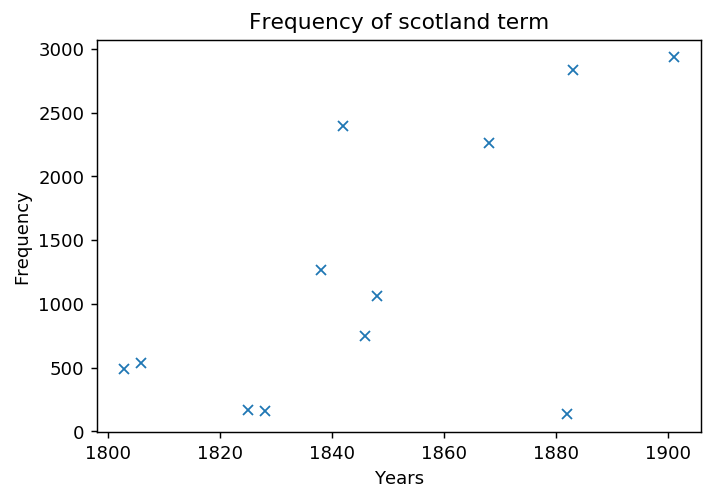

In [11]:
scotland_f_count=freq_count(scotland_vdf)
mpl.rcParams['figure.dpi']=130
plot_freq_count(scotland_f_count, "scotland")

In [12]:
#displaying the same information as a dictionary - keys are the years, and values are frequencies
scotland_f_count

{1803: 489,
 1806: 534,
 1825: 165,
 1828: 157,
 1838: 1263,
 1842: 2398,
 1846: 748,
 1848: 1063,
 1868: 2258,
 1882: 134,
 1883: 2835,
 1901: 2933}

##### Normalizing Frequencies of Scotland

In [13]:
# This cell I just need to run it once - to calculate the normalized SET of publications:
#YEAR, [VOLUMES, PAGES, WORDS]

norm_publication=read_query_results('./results_Gazetteer/results_norm_gaz')
#for printing the values, we are going to sort the values by the years. 
#e.g --> First: 1806 year, with 1 volum, 594 pages, and 426808 words. 
#e.g --> Last: 1825 year, with 1 volum , 222 pages and 182032 words.

sorted(norm_publication.items())

[(1803, [1, 606, 429137]),
 (1806, [1, 594, 426808]),
 (1825, [1, 222, 182032]),
 (1828, [1, 376, 83346]),
 (1838, [2, 1098, 865559]),
 (1842, [2, 1798, 2221435]),
 (1846, [2, 1302, 1520380]),
 (1848, [1, 878, 1093503]),
 (1868, [2, 1908, 2181484]),
 (1882, [1, 492, 389159]),
 (1883, [6, 2038, 2516567]),
 (1901, [1, 1776, 2481536])]

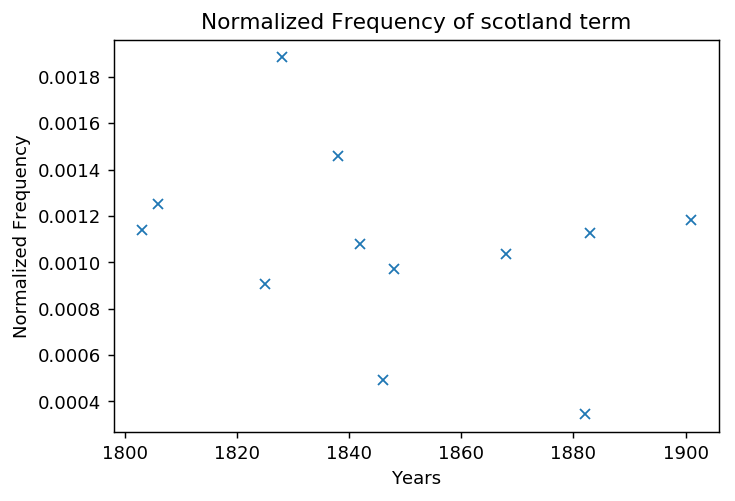

In [14]:
norm_scotland_f_count=plot_normalize_freq(norm_publication, scotland_f_count, "scotland")

###  Exploring "Edinburgh" Term

First we select the rows from the dataframe that has the **"edinburgh"** string in the "term" column, and count the number of elements. 

Later we visualize the left and right words for each **"edinburgh"** term found

And finally, we visualize the frequency of the **"edinburgh"** over the years.

In [15]:
edinburgh_vdf= visualize_term(df, "edinburgh")
print("The number of hits is: %s" %edinburgh_vdf['term'].value_counts())
#Just printing the first 10 hits, since we have 11543 rows for this term
edinburgh_vdf.head(10)

The number of hits is: edinburgh    11797
Name: term, dtype: int64


,year,words_left,term,words_right
2,1803,"v', 'chalmers', 'castlestreet', 'sold', 'by', 'bell', 'bradfute', 'and', 'a', 'constable'",edinburgh,"'j', 'gillies', 'glasgow', 'j', 'burnet', 'aberdeen', 'w', 'morison', 'and', 'd']"
42,1803,"also', 'found', 'at', 'moffat', 'and', 'at', 'st', 'bernards', 'well', 'near'",edinburgh,"'many', 'of', 'the', 'springs', 'affo', 'hold', 'fbme', 'neutral', 'fait', 'diflolved']"
66,1803,"establishment', 'of', 'society', 'schools', 'in', 'that', 'glasgow', 'the', 'bishoprie...",edinburgh,"'dunkeld', 'dumblane', 'brehin', 'aberdeen', 'moray', 'ross', 'caithness', 'orkney', ..."
70,1803,"kings', 'college', 'in', 'old', 'aberdeen', 'marischal', 'college', 'in', 'new', 'aber...",edinburgh,"'anc', 'k', 'glasgow', 'of', 'which', 'an', 'account', 'will', 'be', 'found']"
90,1803,"ocoh', 'the', 'following', 'extracts', 'from', 'mr', 'creechs', 'ftatiftical', 'accoun...",edinburgh,"'ihews', 'a', 'comparative', 'state', 'of', 'the', 'revenues', 'arising', 'from', 'the']"
119,1803,"the', 'taxes', 'imposed', 'upon', 'the', 'inhabitants', 'of', 'the', 'city', 'of'",edinburgh,"'for', 'ministers', 'itipends', 'support', 'of', 'the', 'poor', 'from', 'paying', 'im..."
127,1803,"any', 'other', 'court', 'in', 'scotland', 'v', 'the', 'commissary', 'court', 'of'",edinburgh,"'like', 'that', 'of', 'the', 'admiralty', 'is', 'in', 'some', 'respects', 'supreme']"
128,1803,"or', 'commiffaries', 'are', 'nominated', 'by', 'the', 'crown', 'the', 'court', 'of'",edinburgh,"'has', 'four', 'commif', 'taries', 'these', 'courts', 'were', 'inftkuted', 'by', 'que..."
129,1803,"debts', 'not', 'exceeding', 'i', 'sterling', 'the', 'court', 'of', 'commiffary', 'cf'",edinburgh,"'reviews', 'the', 'decrees', 'of', 'the', 'other', 'commiffary', 'courts', 'takes', '..."
135,1803,"were', 'a', 'commercial', 'parliament', 'which', 'meets', 'once', 'a', 'year', 'at'",edinburgh,"'confuting', 'of', 'a', 'representative', 'from', 'each', 'borough', 'to', 'consult',..."


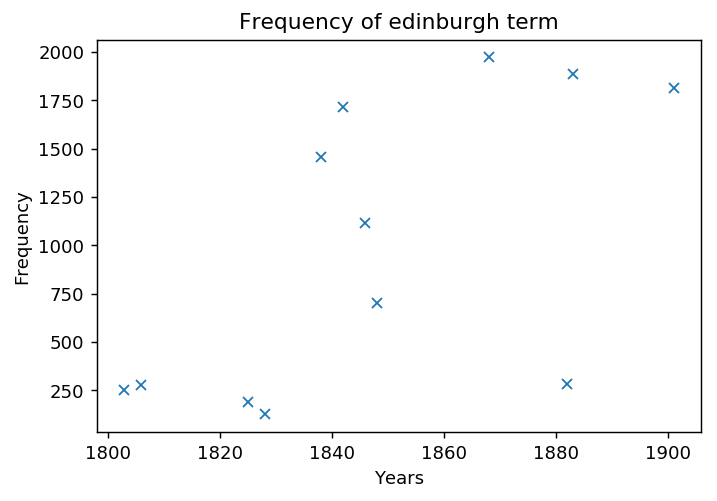

In [16]:
edinburgh_f_count=freq_count(edinburgh_vdf)
plot_freq_count(edinburgh_f_count, "edinburgh")

In [17]:
#displaying the same information as a dictionary - keys are the years, and values are frequencies
edinburgh_f_count

{1803: 254,
 1806: 280,
 1825: 189,
 1828: 127,
 1838: 1459,
 1842: 1714,
 1846: 1115,
 1848: 701,
 1868: 1972,
 1882: 286,
 1883: 1888,
 1901: 1812}

##### Normalizing Frequencies of Edinburgh

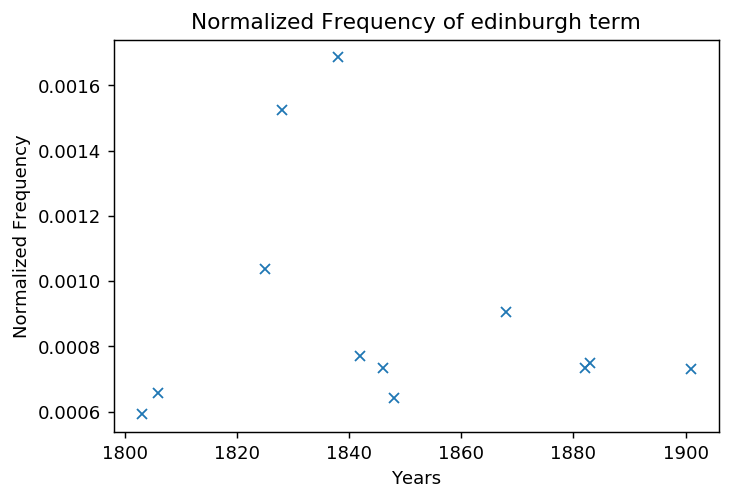

In [18]:
norm_edinburgh_f_count=plot_normalize_freq(norm_publication, edinburgh_f_count, "edinburgh")

###  Exploring "Glasgow" Term

First we select the rows from the dataframe that has the **"glasgow"** string in the "term" column, and count the number of elements. 

Later we visualize the left and right words for each **"glasgow"** term found

And finally, we visualize the frequency of the **"glasgow"** over the years.

In [19]:
glasgow_vdf= visualize_term(df, "glasgow")
print("The number of hits is: %s" %glasgow_vdf['term'].value_counts())
#Just printing the first 10 hits, since we have 12255 rows for this term
glasgow_vdf.head(10)

The number of hits is: glasgow    12412
Name: term, dtype: int64


,year,words_left,term,words_right
3,1803,"sold', 'by', 'bell', 'bradfute', 'and', 'a', 'constable', 'edinburgh', 'j', 'gillies'",glasgow,"'j', 'burnet', 'aberdeen', 'w', 'morison', 'and', 'd', 'peat', 'perth', 'and']"
58,1803,"synod', 'of', 'lothian', 'and', 'tweeddale', 'merfe', 'and', 'teviotdale', 'dumfries',...",glasgow,"'and', 'ayr', 'perth', 'and', 'stirling', 'fife', 'angus', 'and', 'mearns', 'aberdeen']"
67,1803,"greatly', 'promoted', 'by', 'the', 'establishment', 'of', 'society', 'schools', 'in', ...",glasgow,"'the', 'bishopries', 'of', 'edinburgh', 'dunkeld', 'dumblane', 'brehin', 'aberdeen', ..."
72,1803,"old', 'aberdeen', 'marischal', 'college', 'in', 'new', 'aberdeen', 'edinburgh', 'anc',...",glasgow,"'of', 'which', 'an', 'account', 'will', 'be', 'found', 'in', 'the', 'gazetteer']"
260,1803,"commonly', 'produces', 'good', 'crops', 'the', 'great', 'read', 'from', 'carlille', 'to'",glasgow,"'and', 'edinburgh', 'passes', 'through', 'this', 'pariih', 'sir', 'w', 'jardine', 'of']"
285,1803,"and', 'other', 'produce', 'of', 'the', 'country', 'the', 'rising', 'trade', 'of'",glasgow,"'proved', 'very', 'injurious', 'to', 'the', 'trade', 'of', 'this', 'town', 'but']"
326,1803,"distance', 'of', 'miles', 'to', 'be', 'fmelted', 'in', 'a', 'furnace', 'near'",glasgow,"'many', 'of', 'these', 'stones', 'bear', 'distinct', 'imprefiions', 'of', 'pine', 'le..."
334,1803,"are', 'beautifully', 'skirted', 'with', 'wood', 'the', 'roads', 'from', 'edinburgh', 'to'",glasgow,"'and', 'from', 'glasgow', 'to', 'carlisle', 'pass', 'through', 'the', 'parish', 'there']"
335,1803,"with', 'wood', 'the', 'roads', 'from', 'edinburgh', 'to'",glasgow,"'and', 'from', 'glasgow', 'to', 'carlisle', 'pass', 'through', 'the', 'parish', 'ther..."
358,1803,"the', 'finest', 'arable', 'land', 'has', 'been', 'gained', 'the', 'roads', 'from'",glasgow,"'to', 'edinburgh', 'and', 'from', 'glalgow', 'to', 'falkirk', 'by', 'cumbernauld', 'p..."


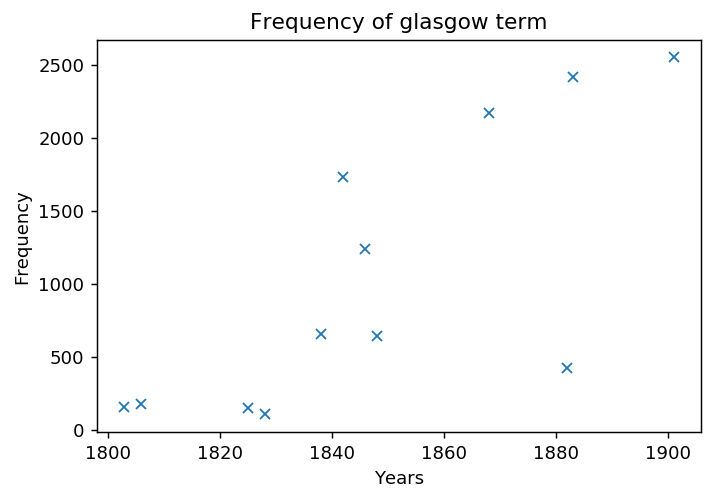

In [20]:
glasgow_f_count=freq_count(glasgow_vdf)
plot_freq_count(glasgow_f_count, "glasgow")

In [21]:
#displaying the same information as a dictionary - keys are the years, and values are frequencies
glasgow_f_count

{1803: 157,
 1806: 174,
 1825: 150,
 1828: 106,
 1838: 659,
 1842: 1729,
 1846: 1237,
 1848: 644,
 1868: 2169,
 1882: 421,
 1883: 2417,
 1901: 2549}

##### Normalizing Frequencies of Glasgow

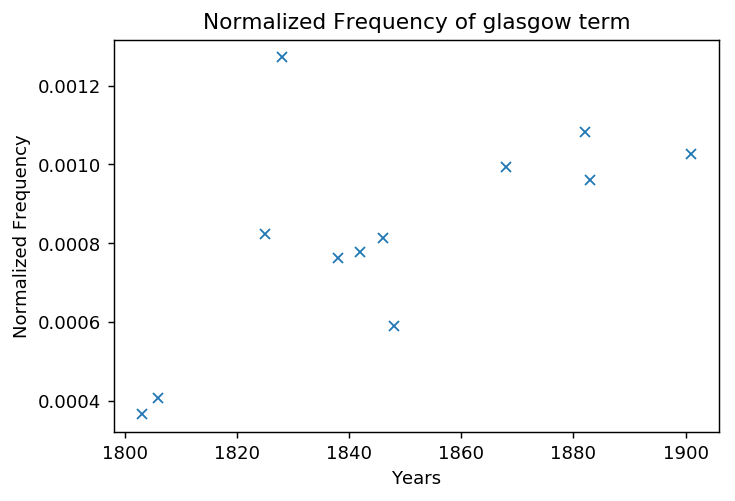

In [22]:
norm_glasgow_f_count=plot_normalize_freq(norm_publication, glasgow_f_count, "glasgow")

###  Exploring "Stirling" Term

First we select the rows from the dataframe that has the **"stirling"** string in the "term" column, and count the number of elements. 

Later we visualize the left and right words for each **"stirling"** term found

And finally, we visualize the frequency of the **"stirling"** over the years.

In [23]:
stirling_vdf= visualize_term(df, "stirling")
print("The number of hits is: %s" %stirling_vdf['term'].value_counts())
#Just printing the first 10 hits, since we have 4082 rows for this term
stirling_vdf.head(10)

The number of hits is: stirling    4192
Name: term, dtype: int64


,year,words_left,term,words_right
64,1803,"merfe', 'and', 'teviotdale', 'dumfries', 'galloway', 'glasgow', 'and', 'ayr', 'perth',...",stirling,"'fife', 'angus', 'and', 'mearns', 'aberdeen', 'moray', 'ross', 'sutherland', 'and', '..."
145,1803,"was', 'composed', 'of', 'certain', 'burgesses', 'from', 'the', 'towns', 'of', 'edinburgh'",stirling,"'berwick', 'and', 'roxburgh', 'who', 'were', 'appointed', 'to', 'meet', 'annually', '..."
163,1803,"union', 'are', 'to', 'be', 'kept', 'constantly', 'in', 'repair', 'viz', 'edinburgh'",stirling,"'dumbarton', 'and', 'blackness', 'and', 'there', 'are', 'several', 'other', 'sorts', ..."
242,1803,"pafling', 'by', 'dumblane', 'falls', 'into', 'the', 'forth', 'a', 'little', 'above'",stirling,"'bridge', 'its', 'course', 'is', 'rapid', 'some', 'salmons', 'are', 'got', 'in']"
244,1803,"of', 'clackmannan', 'is', 'in', 'fact', 'annexed', 'to', 'the', 'county', 'of'",stirling,"'it', 'extends', 'over', 'a', 'part', 'of', 'the', 'ochill', 'hills', 'and']"
288,1803,"druids', 'population', 'in', 'balfron', 'a', 'parish', 'in', 'the', 'county', 'of'",stirling,"'extending', 'about', 'miles', 'in', 'length', 'and', 'in', 'breadth', 'the', 'surface']"
292,1803,"there', 'are', 'abundance', 'of', 'excellent', 'fish', 'the', 'military', 'road', 'from'",stirling,"'to', 'sort', 'william', 'pafies', 'through', 'the', 'parim', 'the', 'number', 'of']"
324,1803,"seems', 'completely', 'to', 'command', 'the', 'passage', 'of', 'the', 'forth', 'to'",stirling,"'it', 'is', 'one', 'of', 'the', 'sorts', 'which', 'by', 'the', 'articles']"
328,1803,"j', 'sinclair', 'blane', 'a', 'small', 'river', 'in', 'the', 'county', 'of'",stirling,"'it', 'has', 'its', 'source', 'in', 'earls', 'seat', 'one', 'of', 'lennox']"
337,1803,"in', 'about', 'bothkennar', 'a', 'small', 'parish', 'in', 'the', 'county', 'of'",stirling,"'forming', 'a', 'square', 'of', 'about', 'imile', 'it', 'is', 'perfectly', 'level']"


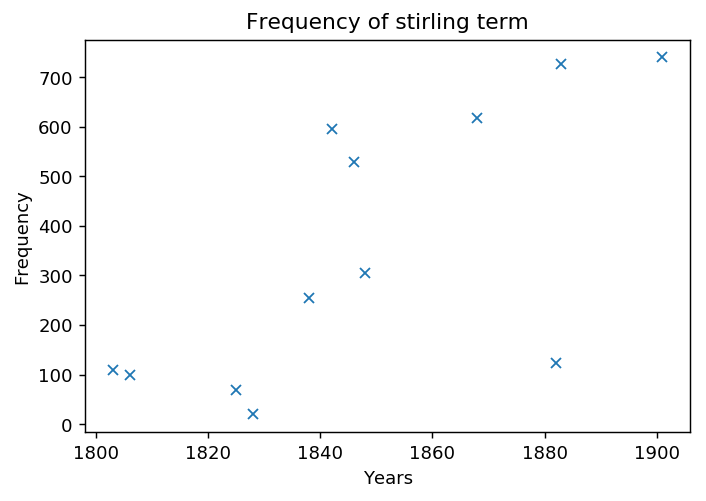

In [24]:
stirling_f_count=freq_count(stirling_vdf)
plot_freq_count(stirling_f_count, "stirling")

In [25]:
#displaying the same information as a dictionary - keys are the years, and values are frequencies
stirling_f_count

{1803: 110,
 1806: 100,
 1825: 69,
 1828: 20,
 1838: 255,
 1842: 596,
 1846: 529,
 1848: 306,
 1868: 617,
 1882: 124,
 1883: 726,
 1901: 740}

##### Normalizing Frequencies of Stirling

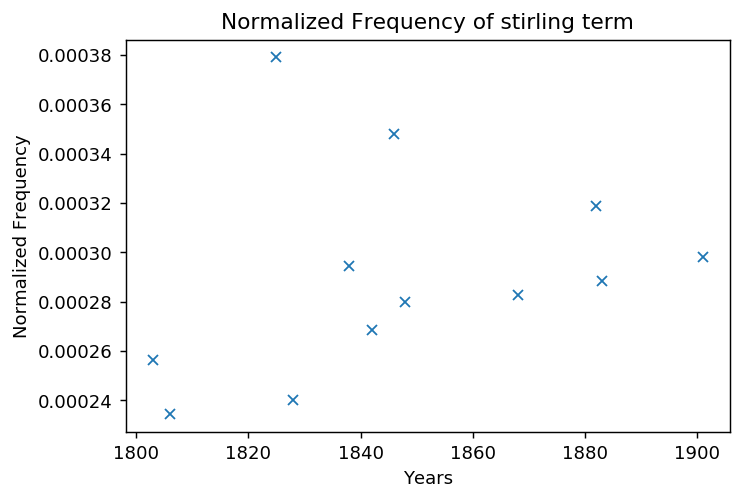

In [26]:
norm_stirling_f_count=plot_normalize_freq(norm_publication, stirling_f_count, "stirling")

###  Exploring "Aberdeen" Term
First we select the rows from the dataframe that has the **"aberdeen"** string in the "term" column, and count the number of elements. 

Later we visualize the left and right words for each **"aberdeen"** term found

And finally, we visualize the frequency of the **"aberdeen"** over the years.

In [27]:
aberdeen_vdf= visualize_term(df, "aberdeen")
print("The number of hits is: %s" % aberdeen_vdf['term'].value_counts())
#Just printing the first 10 hits, since we have 5137 rows for this term
aberdeen_vdf.head(10)

The number of hits is: aberdeen    5277
Name: term, dtype: int64


,year,words_left,term,words_right
0,1803,"bradfute', 'and', 'a', 'constable', 'edinburgh', 'j', 'gillies', 'glasgow', 'j', 'burnet'",aberdeen,"'w', 'morison', 'and', 'd', 'peat', 'perth', 'and', 'longman', 'rees', 'london']"
57,1803,"glasgow', 'and', 'ayr', 'perth', 'and', 'stirling', 'fife', 'angus', 'and', 'mearns'",aberdeen,"'moray', 'ross', 'sutherland', 'and', 'caithness', 'argyll', 'glenelg', 'orkney', 'to..."
65,1803,"in', 'that', 'glasgow', 'the', 'bishopries', 'of', 'edinburgh', 'dunkeld', 'dumblane',...",aberdeen,"'moray', 'ross', 'caithness', 'orkney', 'galloway', 'aryll', 'or', 'lismore', 'and', ..."
68,1803,"has', 'five', 'universities', 'viz', 'st', 'andrews', 'kings', 'college', 'in', 'old'",aberdeen,"'marischal', 'college', 'in', 'new', 'aberdeen', 'edinburgh', 'anc', 'k', 'glasgow', ..."
69,1803,"andrews', 'kings', 'college', 'in', 'old'",aberdeen,"'marischal', 'college', 'in', 'new', 'aberdeen', 'edinburgh', 'anc', 'k', 'glasgow', ..."
175,1803,"upwards', 'of', 'i', 'sterling', 'it', 'unites', 'with', 'the', 'burghs', 'of'",aberdeen,"'montrofe', 'inverbervie', 'and', 'brechin', 'in', 'sending', 'a', 'representative', ..."
186,1803,"the', 'most', 'valuable', 'articles', 'from', 'those', 'in', 'the', 'neighbourhood', 'of'",aberdeen,"'tons', 'and', 'upwards', 'are', 'annually', 'exported', 'to', 'london', 'the', 'value']"
187,1803,"and', 'a', 'vein', 'of', 'manganeze', 'in', 'the', 'neighbourhood', 'of', 'old'",aberdeen,"'in', 'the', 'parish', 'of', 'huntly', 'there', 'are', 'many', 'indications', 'of']"
188,1803,"and', 'fail', 'cloth', 'manufactures', 'have', 'been', 'successfully', 'introduced', '...",aberdeen,"'peterhead', 'and', 'huntly', 'which', 'latter', 'according', 'to', 'the', 'report', ..."
189,1803,"the', 'paifley', 'of', 'the', 'north'",aberdeen,"enfhire', 'contains', 'royal', 'boroughs', 'viz', 'aberdeen', 'kintore', 'and', 'inver..."


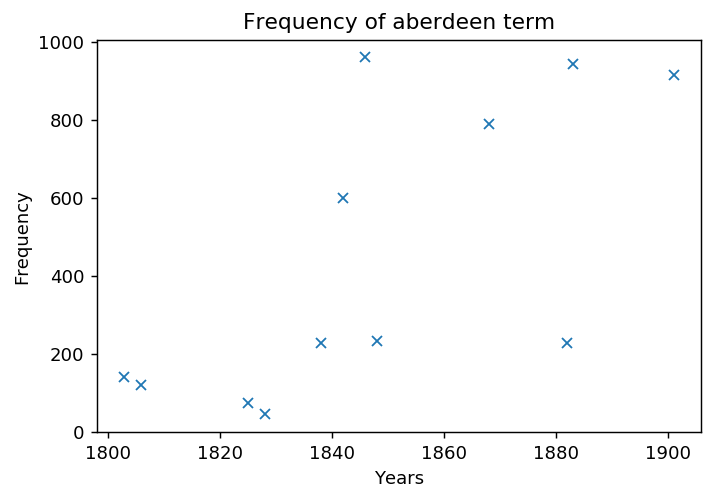

In [28]:
aberdeen_f_count=freq_count(aberdeen_vdf)
plot_freq_count(aberdeen_f_count, "aberdeen")

In [29]:
#displaying the same information as a dictionary - keys are the years, and values are frequencies
aberdeen_f_count

{1803: 140,
 1806: 121,
 1825: 74,
 1828: 45,
 1838: 229,
 1842: 599,
 1846: 960,
 1848: 234,
 1868: 789,
 1882: 228,
 1883: 942,
 1901: 916}

##### Normalizing Frequencies of aberdeen

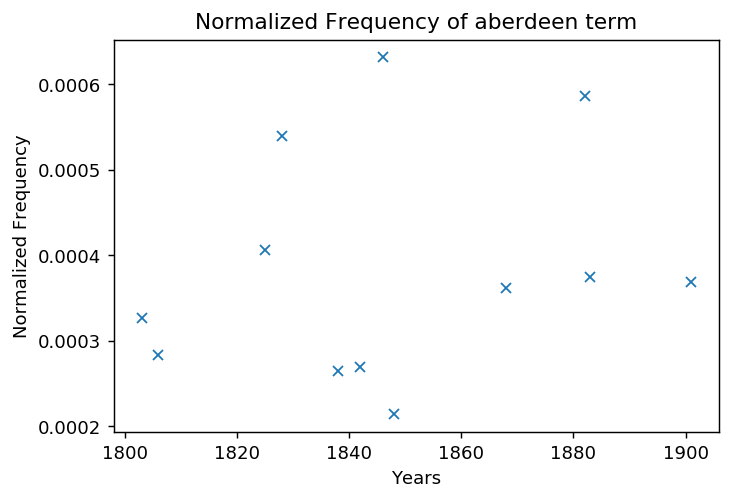

In [30]:
norm_aberdeen_f_count=plot_normalize_freq(norm_publication, aberdeen_f_count, "aberdeen")

### Exploring "Inverness" Term

First we select the rows from the dataframe that has the "inverness" string in the "term" column, and count the number of elements.

Later we visualize the left and right words for each "inverness" term found

And finally, we visualize the frequency of the "inverness" over the years.


In [31]:
inverness_vdf= visualize_term(df, "inverness")
print("The number of hits is: %s" %inverness_vdf['term'].value_counts())
#Just printing the first 10 hits, since we have 3592 rows for this term
inverness_vdf.head(10)

The number of hits is: inverness    3687
Name: term, dtype: int64


,year,words_left,term,words_right
12,1803,"termed', 'the', 'moray', 'frith', 'and', 'extends', 'inland', 'as', 'far', 'as'",inverness,"'the', 'n', 'coast', 'of', 'this', 'gap', 'is', 'indented', 'by', 'the']"
225,1803,"is', 'nearly', 'equally', 'divided', 'between', 'the', 'counties', 'of', 'murray', 'and'",inverness,"'it', 'is', 'about', 't', 'miles', 'in', 'length', 'and', 'from', 'to']"
261,1803,"haig', 'loch', 'a', 'fresh', 'water', 'lake', 'in', 'the', 'county', 'of'",inverness,"'it', 'is', 'miles', 'long', 'and', 'if', 'broad', 'it', 'is', 'of']"
265,1803,"in', 'was', 'ardersier', 'this', 'parish', 'lies', 'in', 'the', 'county', 'of'",inverness,"'its', 'length', 'is', 'miles', 'and', 'its', 'breadth', 'the', 'same', 'its']"
281,1803,"by', 'a', 'company', 'of', 'invalids', 'and', 'supplied', 'with', 'provisions', 'from'",inverness,"'by', 'a', 'loop', 'of', 'tons', 'though', 'the', 'fortification', 'is', 'hi']"
287,1803,"bl', 'badenoch', 'the', 'most', 'easterly', 'dif', 'tricb', 'of'",inverness,"ire', 'having', 'inverness', 'on', 'the', 'n', 'moray', 'on', 'the', 'e', 'athol', 'on..."
296,1803,"of', 'the', 'same', 'name', 'it', 'lies', 'ia', 'miles', 'w', 'of'",inverness,"'beauly', 'a', 'river', 'in', 'invernessfhire', 'it', 'is', 'formed', 'by', 'the']"
320,1803,"of', 'the', 'earl', 'of', 'aboyne', 'the', 'road', 'from', 'dundee', 'to'",inverness,"'by', 'the', 'cairn', 'mount', 'runs', 'through', 'the', 'parish', 'large', 'upright']"
329,1803,"abertarf', 'these', 'united', 'pariihes', 'are', 'situated', 'in', 'the', 'county', 'of'",inverness,"'they', 'extend', 'in', 'length', 'about', 'and', 'in', 'breadth', 'about', 'miles']"
381,1803,"rock', 'population', 'of', 'canna', 'about', 'c', 'camnich', 'a', 'stream', 'in'",inverness,"'shire', 'which', 'united', 'with', 'other', 'itreams', 'near', 'erchlesscastle', 'fo..."


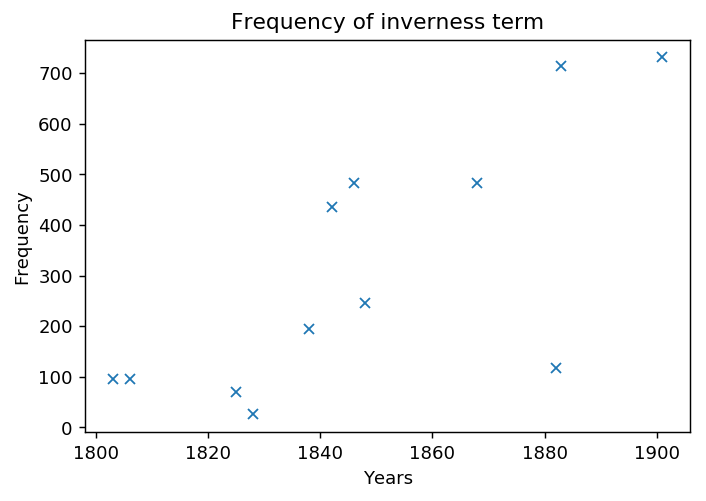

In [32]:
inverness_f_count=freq_count(inverness_vdf)
plot_freq_count(inverness_f_count, "inverness")

In [33]:
#displaying the same information as a dictionary - keys are the years, and values are frequencies
inverness_f_count

{1803: 95,
 1806: 96,
 1825: 70,
 1828: 26,
 1838: 194,
 1842: 435,
 1846: 482,
 1848: 245,
 1868: 483,
 1882: 117,
 1883: 713,
 1901: 731}

##### Normalizing Frequencies of inverness

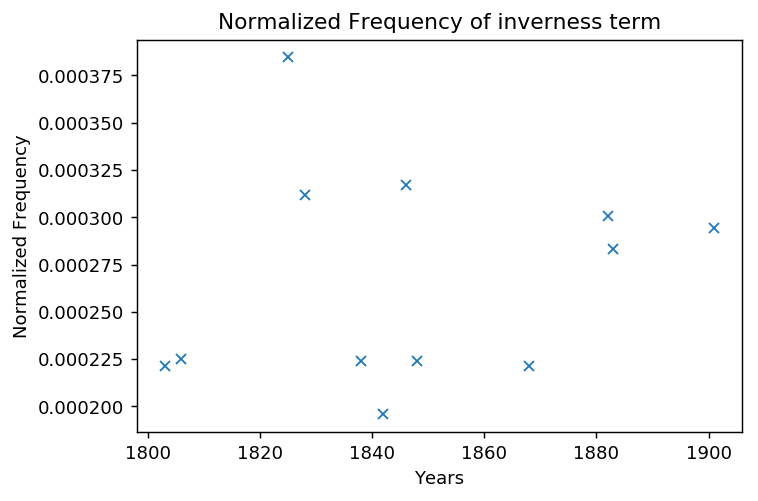

In [34]:
norm_inverness_f_count=plot_normalize_freq(norm_publication, inverness_f_count, "inverness")

### Exploring "Perth" Term

First we select the rows from the dataframe that has the "perth" string in the "term" column, and count the number of elements.

Later we visualize the left and right words for each "perth" term found

And finally, we visualize the frequency of the "perth" over the years.

In [35]:
perth_vdf= visualize_term(df, "perth")
print("The number of hits is: %s" %perth_vdf['term'].value_counts())
#Visualizing the first 10 rows, since we have 5840 rows with this term
perth_vdf.head(10)

The number of hits is: perth    5687
Name: term, dtype: int64


,year,words_left,term,words_right
4,1803,"gillies', 'glasgow', 'j', 'burnet', 'aberdeen', 'w', 'morison', 'and', 'd', 'peat'",perth,"'and', 'longman', 'rees', 'london']"
59,1803,"and', 'tweeddale', 'merfe', 'and', 'teviotdale', 'dumfries', 'galloway', 'glasgow', 'a...",perth,"'and', 'stirling', 'fife', 'angus', 'and', 'mearns', 'aberdeen', 'moray', 'ross', 'su..."
183,1803,"on', 'the', 's', 'by', 'the', 'counties', 'of', 'kincardine', 'angus', 'and'",perth,"'and', 'on', 'the', 'w', 'by', 'banff', 'murray', 'and', 'invernessshires', 'it']"
223,1803,"aberfeldie', 'a', 'small', 'but', 'improving', 'village', 'in', 'the', 'county', 'of'",perth,"'it', 'is', 'situated', 'on', 'the', 'banks', 'of', 'the', 'tay', 'about']"
226,1803,"a', 'conhderable', 'manufactory', 'of', 'household', 'linen', 'and', 'jihjias', 'for',...",perth,"'market', 'the', 'road', 'from', 'brechin', 'to', 'forfar', 'erected', 'pariih', 'of']"
229,1803,"that', 'of', 'abernyte', 'a', 'parish', 'situated', 'in', 'the', 'county', 'of'",perth,"'amongst', 'those', 'hills', 'that', 'rise', 'gradually', 'from', 'the', 'carfe', 'of']"
239,1803,"logie', 'amon', 'methven', 'and', 'regorton', 'falls', 'into', 'the', 'tay', 'above'",perth,"'after', 'a', 'course', 'of', 'near', 'miles', 'the', 'banks', 'are', 'rocky']"
243,1803,"the', 'pariih', 'of', 'alyth', 'is', 'situated', 'in', 'the', 'county', 'of'",perth,"'on', 'the', 'north', 'side', 'of', 'the', 'valley', 'of', 'strathmore', 'it']"
256,1803,"a', 'small', 'rivulet', 'in', 'the', 'parish', 'of', 'kilmadock', 'county', 'of'",perth,"'it', 'joins', 'the', 'teith', 'at', 'the', 'church', 'of', 'kilmadock', 'and']"
267,1803,"the', 'iriih', 'sea', 'and', 'the', 'clyde', 'on', 'the', 'e', 'by'",perth,"'and', 'dumbartonfhires', 'on', 'the', 'n', 'by', 'invemessshire', 'and', 'on', 'the']"


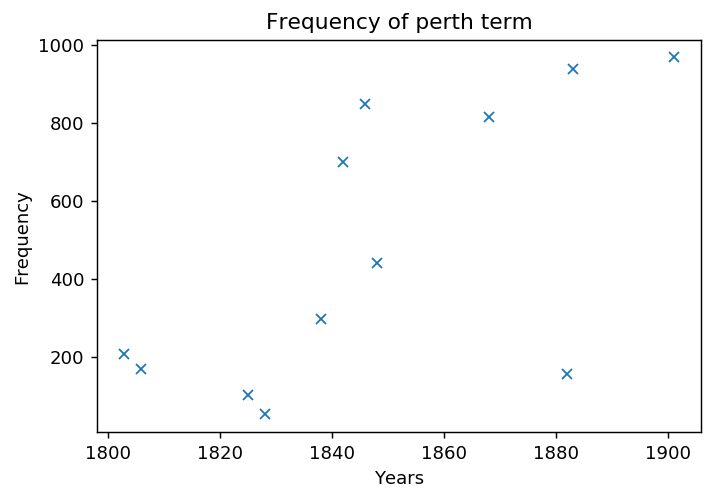

In [36]:
perth_f_count=freq_count(perth_vdf)
plot_freq_count(perth_f_count, "perth")

In [37]:
#displaying the same information as a dictionary - keys are the years, and values are frequencies
perth_f_count

{1803: 207,
 1806: 169,
 1825: 102,
 1828: 52,
 1838: 297,
 1842: 699,
 1846: 848,
 1848: 440,
 1868: 813,
 1882: 155,
 1883: 938,
 1901: 967}

##### Normalizing Frequencies of perth

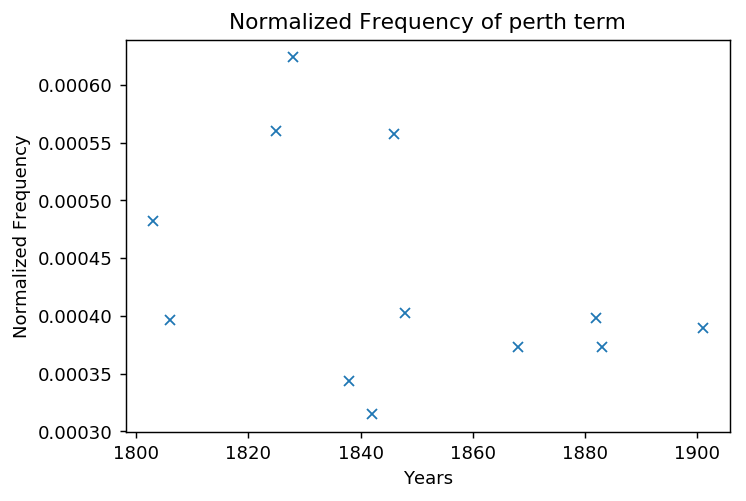

In [38]:
norm_perth_f_count=plot_normalize_freq(norm_publication, perth_f_count, "perth")

### Exploring "Dundee" Term

First we select the rows from the dataframe that has the "dundee" string in the "term" column, and count the number of elements.

Later we visualize the left and right words for each "dundee" term found

And finally, we visualize the frequency of the "dundee" over the years.

## Cumulative Plots

A serie of cumalive plots showing the frequencies of two terms over the years. 

And a final one, showing the frequencies of all of them over the years 

In [39]:
dundee_vdf= visualize_term(df, "dundee")
print("The number of hits is: %s" %dundee_vdf['term'].value_counts())
#Visualizing the first 10 rows, since we have 3034 rows with this term
dundee_vdf.head(10)

The number of hits is: dundee    3123
Name: term, dtype: int64


,year,words_left,term,words_right
1,1803,"nobility', 'and', 'gentry', 'roads', 'ic', 'illustrated', 'with', 'an', 'elegant', 'map'",dundee,"'printed', 'by', 'e', 'ray', 'for', 'v', 'chalmers', 'castlestreet', 'sold', 'by']"
25,1803,"the', 'eastern', 'sea', 'the', 'toy', 'discharges', 'into', 'the', 'ocean', 'below'",dundee,"'a', 'greater', 'quantity', 'of', 'water', 'than', 'perhaps', 'any', 'river', 'of']"
172,1803,"reclion', 'of', 'the', 'great', 'in', 'road', 'about', 'miles', 'e', 'from'",dundee,"'n', 'n', 'e', 'of', 'edinburgh', 'and', 'w', 'from', 'montrofe', 'the']"
245,1803,"the', 'parish', 'andconfidera', 'we', 'quantities', 'of', 'lime', 'are', 'brought', 'f...",dundee,"'miles', 'for', 'the', 'purpose', 'of', 'manure', 'very', 'extensive', 'moffes', 'sup..."
250,1803,"sandy', 'shore', 'with', 'sunk', 'rocks', 'besides', 'the', 'principal', 'harbours', 'of'",dundee,"'aberbrothock', 'and', 'montrofe', 'there', 'are', 'a', 'few', 'places', 'where', 'sm..."
251,1803,"the', 'trade', 'of', 'this', 'hire', 'angusfliire', 'contains', 'royal', 'boroughs', '...",dundee,"'arbreath', 'montrofe', 'brechin']"
303,1803,"manufactory', 'was', 'established', 'some', 'time', 'ago', 'by', 'a', 'company', 'of'",dundee,"'merchants', 'which', 'has', 'been', 'of', 'great', 'service', 'to', 'the', 'neighbou..."
319,1803,"the', 'estate', 'of', 'the', 'earl', 'of', 'aboyne', 'the', 'road', 'from'",dundee,"'to', 'inverness', 'by', 'the', 'cairn', 'mount', 'runs', 'through', 'the', 'parish']"
467,1803,"supporters', 'of', 'the', 'house', 'of', 'stuart', 'commanded', 'by', 'lord', 'viscount'",dundee,"'in', 'which', 'the', 'latter', 'were', 'completely', 'defeated', 'the', 'number', 'of']"
470,1803,"haddocks', 'which', 'they', 'carry', 'in', 'open', 'boats', 'to', 'montrofe', 'arbroath'",dundee,"'and', 'leith', 'the', 'parish', 'of', 'cullen', 'extends', 'about', 'miles', 'in']"


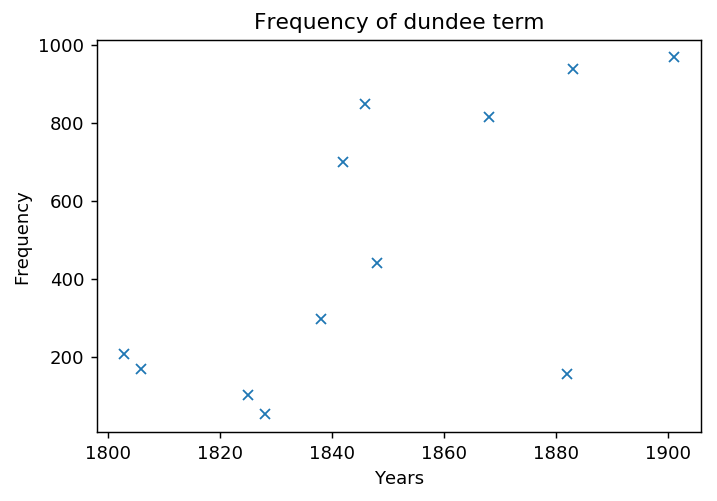

In [40]:
dundee_f_count=freq_count(dundee_vdf)
plot_freq_count(perth_f_count, "dundee")

##### Normalizing Frequencies of dundee

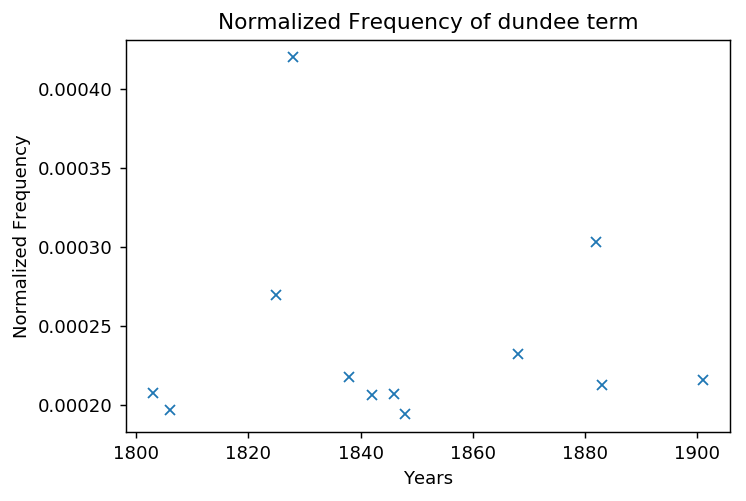

In [41]:
norm_dundee_f_count=plot_normalize_freq(norm_publication, dundee_f_count, "dundee")

## Total Comparative Plots - Without and With Normalizing the frequencies

#### Without Normalizing Frequencies

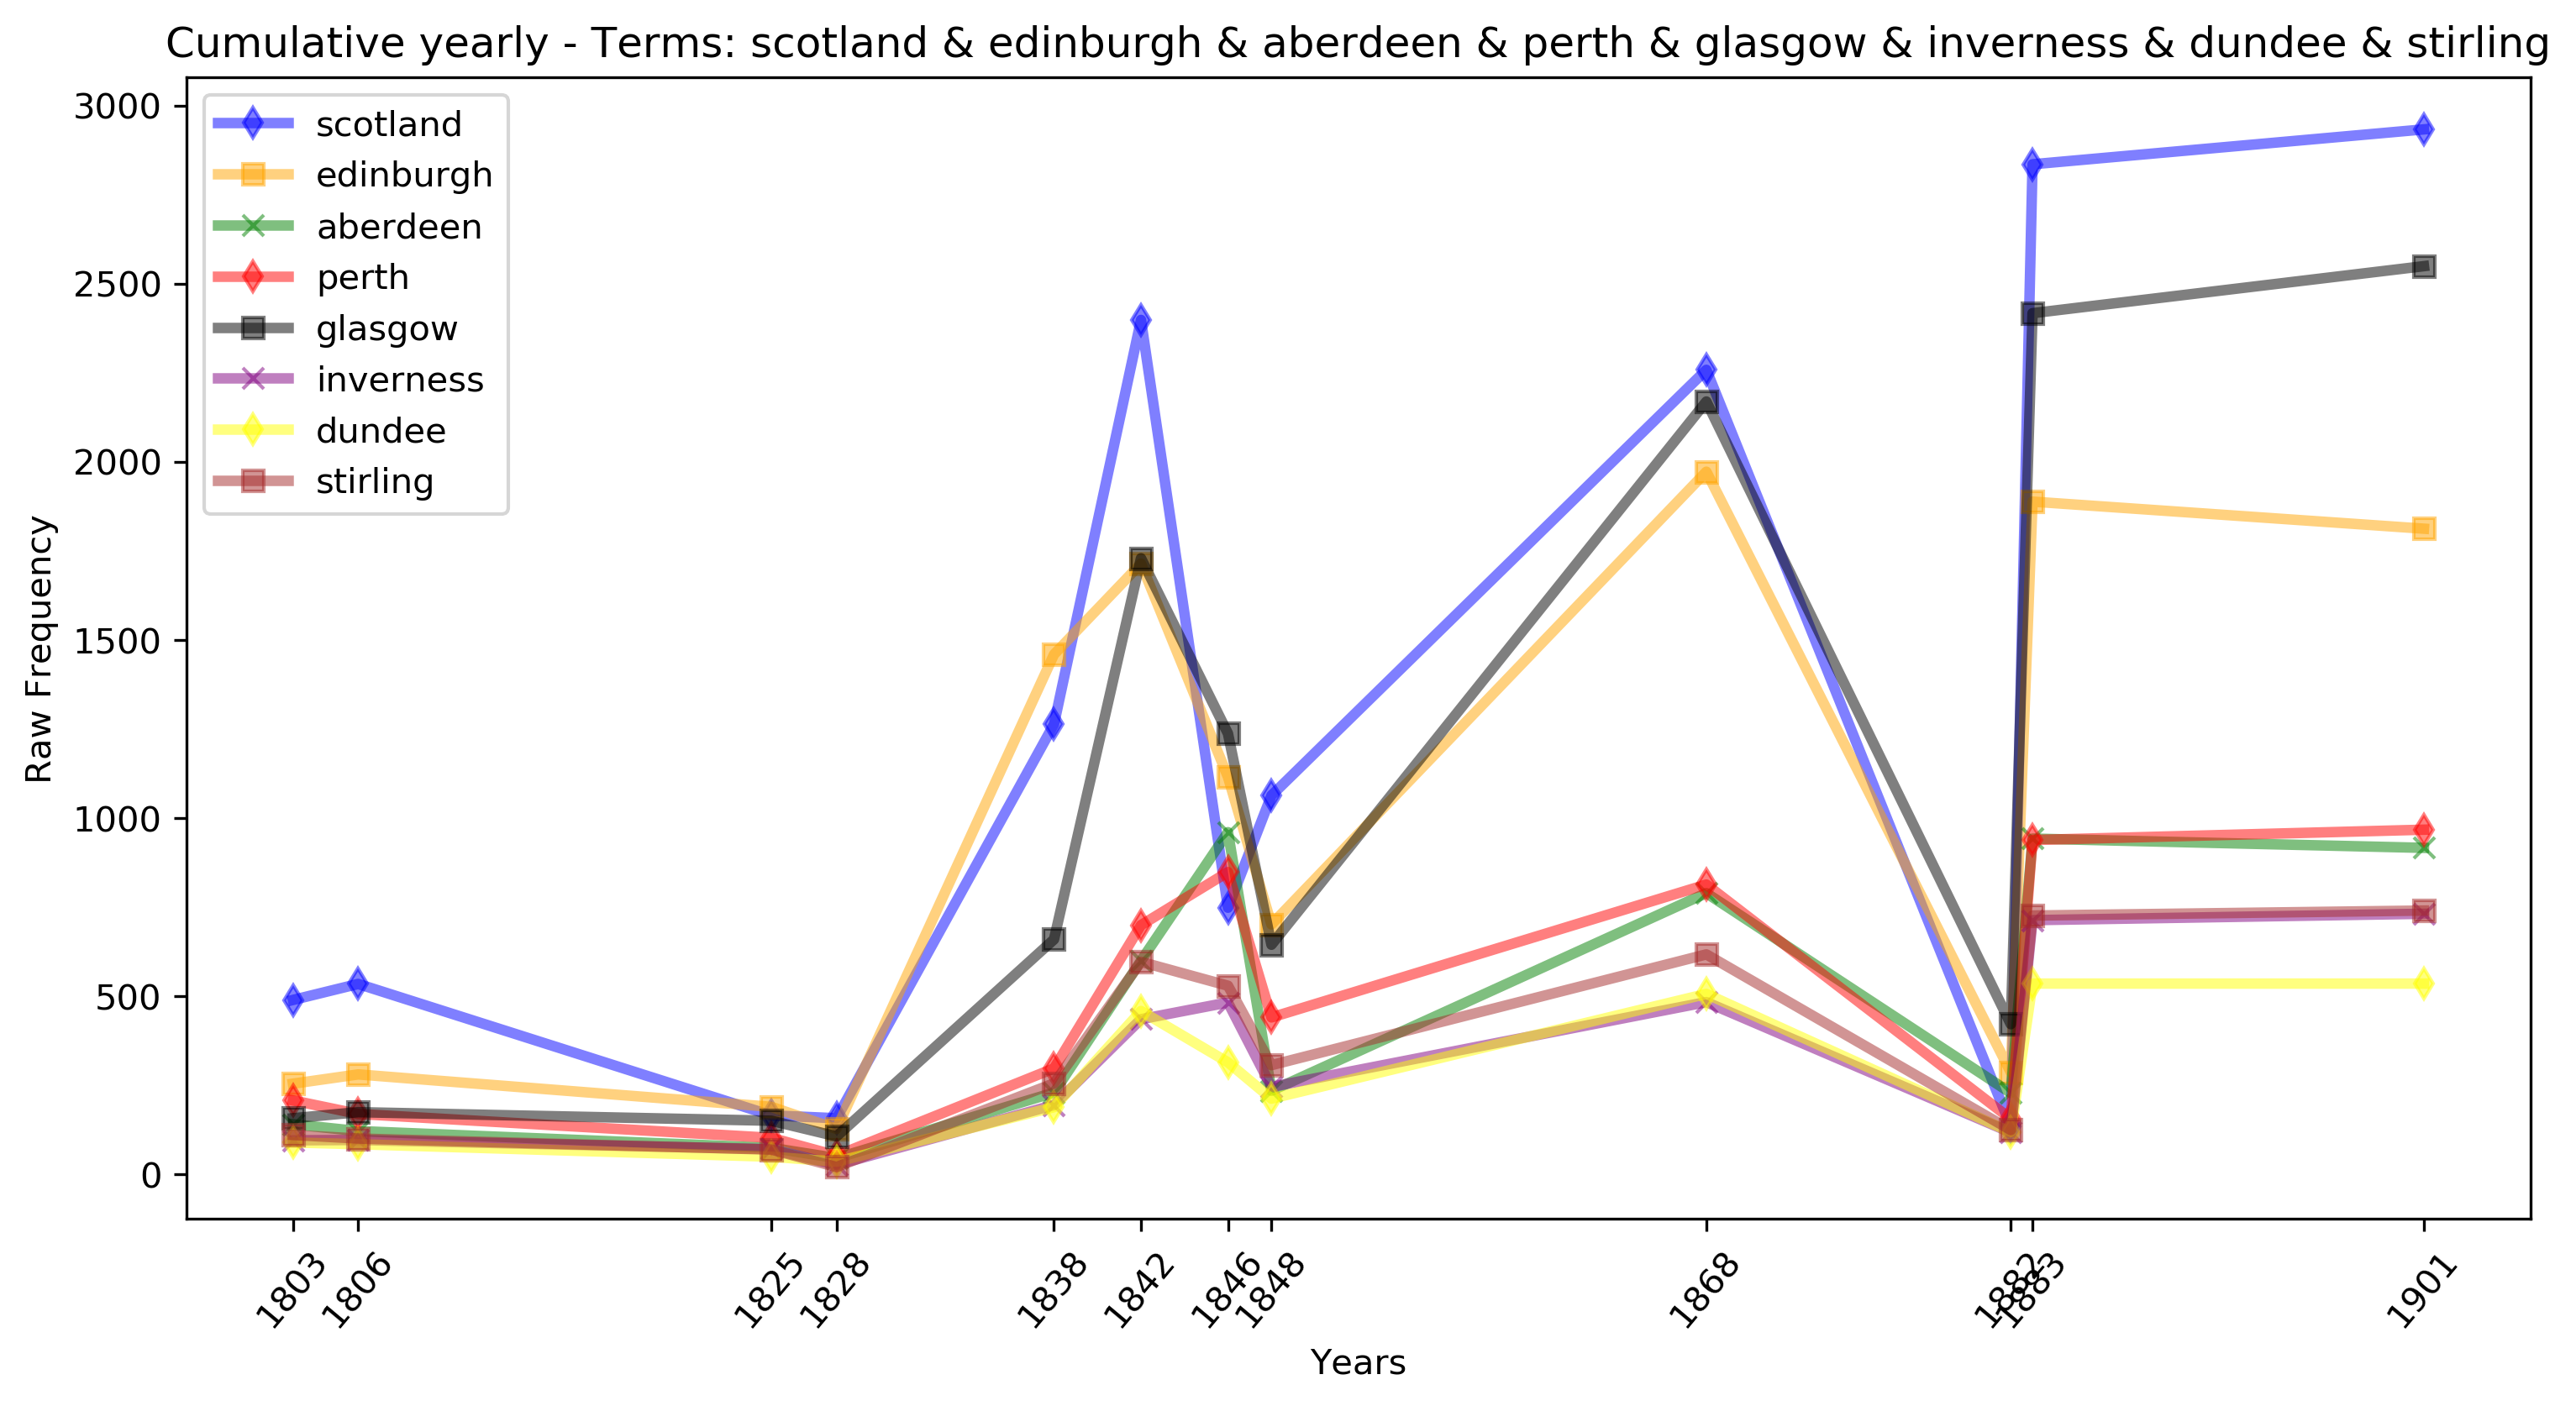

In [42]:
mpl.rcParams['figure.dpi']=300
total_cumulative_plot(scotland_f_count, edinburgh_f_count, aberdeen_f_count, perth_f_count, glasgow_f_count, inverness_f_count, dundee_f_count, stirling_f_count, "scotland", "edinburgh", "aberdeen", "perth", "glasgow", "inverness", "dundee", "stirling", "Raw")

#### With Normalizing Frequencies

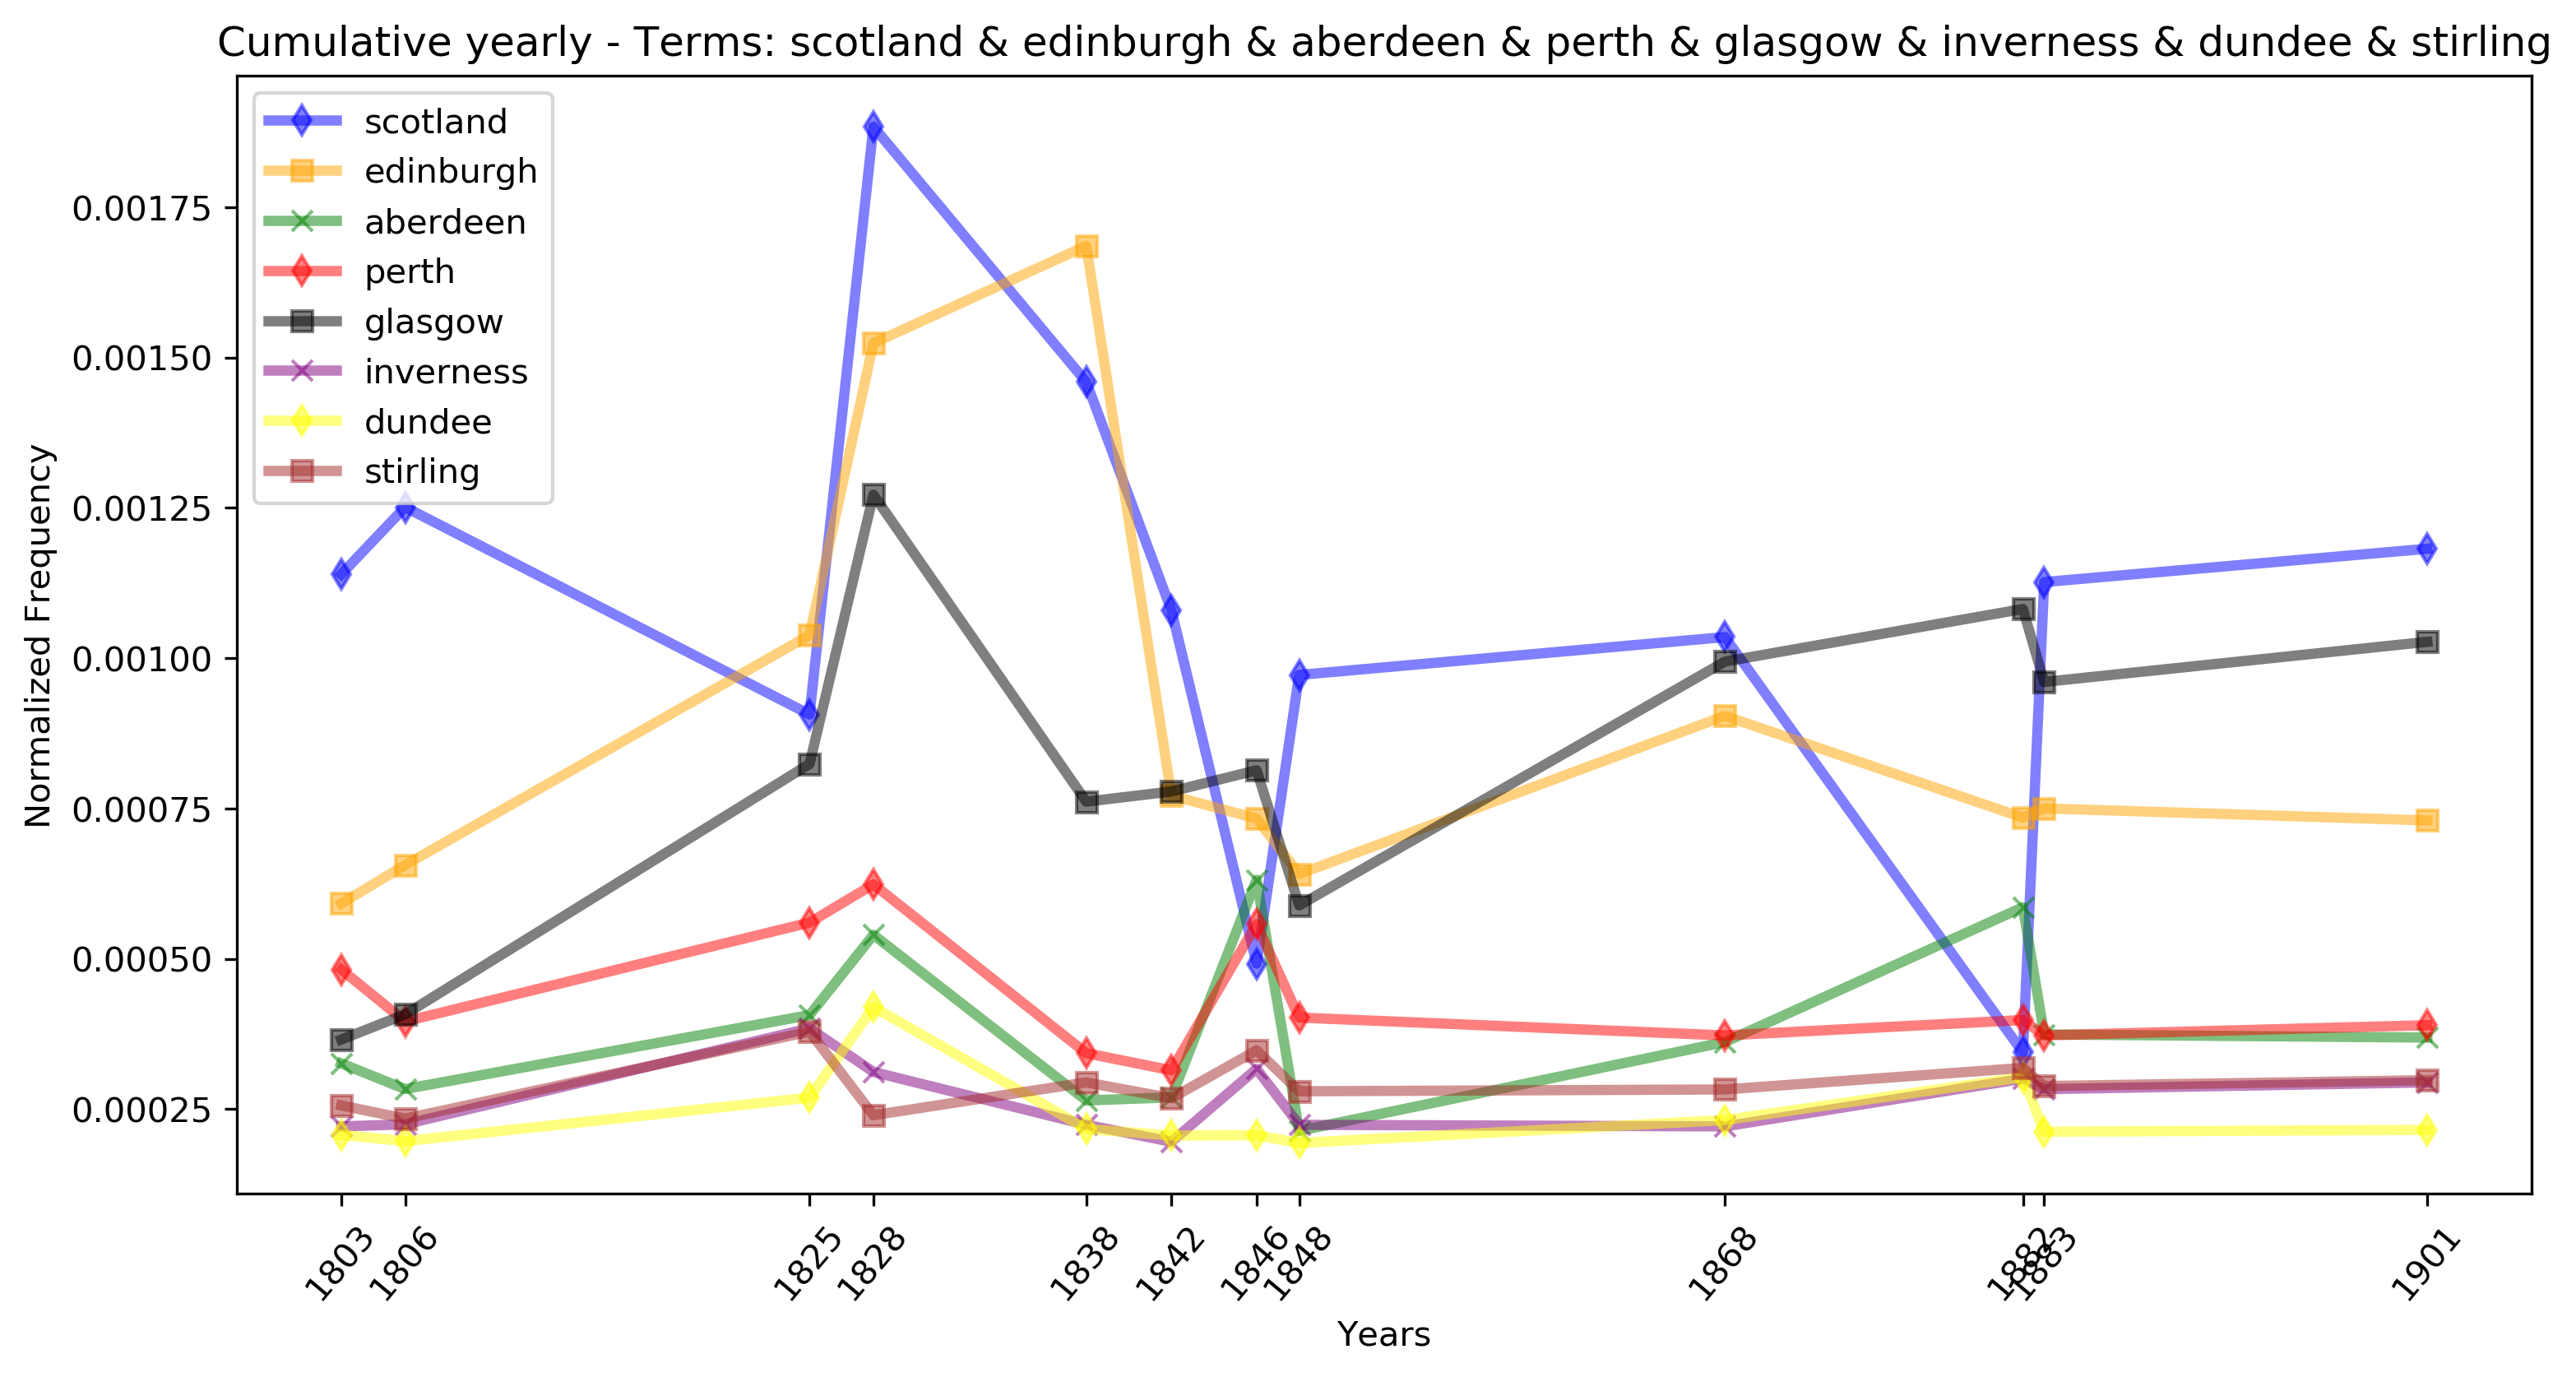

In [43]:
mpl.rcParams['figure.dpi']=300
total_cumulative_plot(norm_scotland_f_count, norm_edinburgh_f_count, norm_aberdeen_f_count, norm_perth_f_count, norm_glasgow_f_count, norm_inverness_f_count, norm_dundee_f_count, norm_stirling_f_count, "scotland", "edinburgh", "aberdeen", "perth", "glasgow", "inverness", "dundee", "stirling", "Normalized")